In [179]:

import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Configurable Parameters
# ===============================

OBSTACLE_RADIUS = 0.06  # 12 cm / 2
GATE_WIDTH = 0.40  # 40 cm gate width

# ===============================
# Environment Definition
# ===============================

START = [-1.0, -3.0]
END = [-0.5, 2.0]

NOMINAL_GATES = [
    [0.5, -2.5, 0, 0, 0, -1.57, 0],
        [-0.5, 1.5, 0, 0, 0, 0, 0],
    [2.0, -1.5, 0, 0, 0, 0, 0],
    [0.0, 0.5, 0, 0, 0, 1.57, 0]

]

NOMINAL_OBSTACLES = [
    [1.5, -2.5, 0],
    [0.5, -1.0, 0],
    [1.5, 0, 0],
    [-1.0, 0, 0]
]

gates = np.array(NOMINAL_GATES)
obstacles = np.array(NOMINAL_OBSTACLES)



In [180]:
from matplotlib import patches

# Create a plot

def plot_environment(gates, obstacles, path=None):
    """Visualize the environment with gates and obstacles."""
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot obstacles as filled circles  
    obstacle_diameter = 0.20 # 12 cm = 0.12 m  
    obstacle_radius = obstacle_diameter / 2  
    
    for obs in obstacles:  
        obs_x, obs_y = obs[0], obs[1]  
        circle = patches.Circle(  
            (obs_x, obs_y),  
            obstacle_radius,  
            linewidth=1,  
            edgecolor='magenta',  
            facecolor='magenta'  # Solid fill color  
        )  
        ax.add_patch(circle)  # Plot obstacles as circles  
    
    # Plot gates as filled rectangles  
    gate_width = 0.6  # 40 cm = 0.4 m  
    gate_height = 0.1  # Assuming a height to visualize the gate in 2D  
    
    for idx, gate in enumerate(gates):
        gate_x, gate_y, _, _, _, yaw, _ = gate  
        
        # Create rotation matrix for the gate  
        angle_rad = yaw  
        rotation_matrix = np.array([  
            [np.cos(angle_rad), -np.sin(angle_rad)],  
            [np.sin(angle_rad),  np.cos(angle_rad)]  
        ])  
        
        # Calculate the adjusted center for the gate  
        displacement = np.dot(rotation_matrix, np.array([gate_width / 2, gate_height / 2]))  
        rect_center_x, rect_center_y = gate_x - displacement[0], gate_y - displacement[1]  
        
        rect = patches.Rectangle(  
            (rect_center_x, rect_center_y),  
            gate_width, gate_height,  
            angle=np.degrees(yaw),  
            linewidth=2,  
            edgecolor='b',  
            facecolor='b'  # Solid fill color  
        )  
        ax.add_patch(rect)
        
        # label the gate with its ID
        ax.text(gate_x, gate_y + 0.1, str(idx), fontsize=12, ha='center', va='center', color='white')
        

    # add start and finish points, use stars

    ax.plot(START[0], START[1], 'g*', label='Start', markersize=10)
    ax.plot(END[0], END[1], 'r*', label='Finish', markersize=10)
    ax.legend()
    
    # Plot path if provided, with arrows 
    if path is not None:
        path = np.array(path)
        ax.plot(path[:, 0], path[:, 1], 'k-', label='Path', linewidth=2)
        for i in range(len(path) - 1):
            ax.annotate('', xy=path[i + 1], xytext=path[i],
                        arrowprops=dict(arrowstyle='->', color='black', lw=2),
                        fontsize=12, ha='center', va='center')
    
    # Set plot limits  
    ax.set_xlim(-3.5, 3.5)  
    ax.set_ylim(-3.5, 3.5)  
    
    # Set aspect ratio  
    ax.set_aspect('equal', 'box')  
    
    # Labels and title  
    ax.set_xlabel('X Position (m)')  
    ax.set_ylabel('Y Position (m)')  
    ax.set_title('Environment Visualization')

    # Show plot  
    plt.grid(True)  
    plt.show()

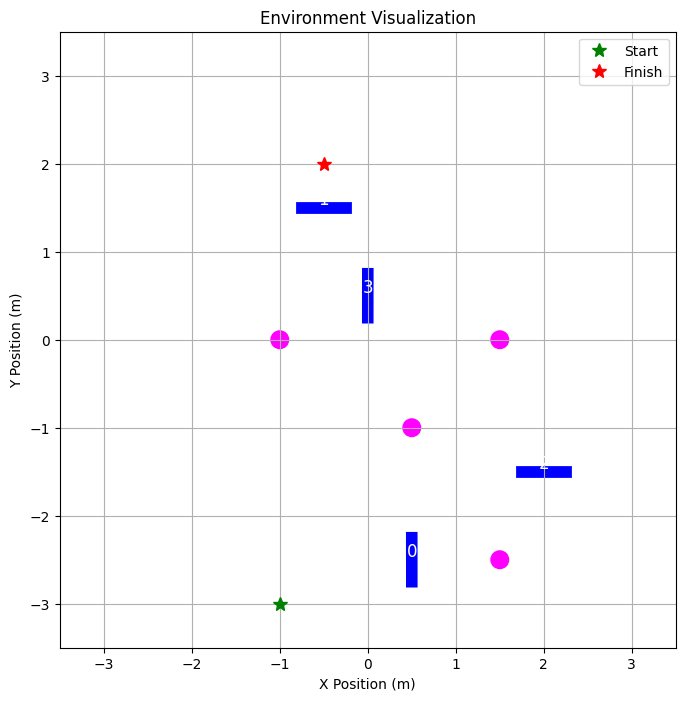

In [181]:
plot_environment(gates, obstacles)

In [182]:
STEP_SIZE = 0.2
SEARCH_RADIUS = 0.5
MAX_ITER = 1000
import random

class Node:
    def __init__(self, pos):
        self.pos = pos
        self.parent = None
        self.cost = 0.0

class RRTStar:
    def __init__(self, x_range, y_range, obstacles, waypoints=None):
        self.x_range = x_range
        self.y_range = y_range
        self.obstacles = obstacles
        if waypoints is None:
            waypoints = []
        self.waypoints = [w[:2] for w in waypoints]
        self.nodes = []

    def plan(self, start, goal):
        self.nodes = [Node(start)]

        # Add waypoints to the path
        path = [start]
        for i, wp in enumerate(self.waypoints):
            path.extend(self.plan_between(path[-1], wp))
        path.extend(self.plan_between(self.waypoints[-1], goal))

        return path

    def plan_between(self, start, goal):
        temp_path = []
        self.nodes = [Node(start)]
        
        for _ in range(MAX_ITER):
            rand_point = self.sample()
            nearest_node = self.nearest(rand_point)
            new_node = self.steer(nearest_node, rand_point)

            if not self.collision_check(nearest_node.pos, new_node.pos):
                neighbors = self.find_nearby_nodes(new_node)
                min_cost_node = self.choose_best_parent(neighbors, nearest_node, new_node)
                if min_cost_node:
                    new_node.parent = min_cost_node
                    new_node.cost = min_cost_node.cost + np.linalg.norm(np.array(new_node.pos) - np.array(min_cost_node.pos))
                self.nodes.append(new_node)
                self.rewire(new_node, neighbors)

                if np.linalg.norm(np.array(new_node.pos) - np.array(goal)) < STEP_SIZE:
                    final_node = Node(goal)
                    final_node.parent = new_node
                    final_node.cost = new_node.cost + np.linalg.norm(np.array(goal) - np.array(new_node.pos))
                    self.nodes.append(final_node)
                    temp_path = self.extract_path(final_node)
                    break
        return temp_path

    def sample(self):
        return [random.uniform(*self.x_range), random.uniform(*self.y_range)]

    def nearest(self, point):
        return min(self.nodes, key=lambda node: np.linalg.norm(np.array(node.pos) - np.array(point)))

    def steer(self, from_node, to_point):
        vec = np.array(to_point) - np.array(from_node.pos)
        dist = np.linalg.norm(vec)
        direction = vec / dist if dist != 0 else vec
        new_pos = from_node.pos + STEP_SIZE * direction
        new_node = Node(new_pos.tolist())
        new_node.parent = from_node
        new_node.cost = from_node.cost + STEP_SIZE
        return new_node

    def collision_check(self, p1, p2):
        for obs in self.obstacles:
            center = obs[:2]
            dist = self.distance_point_to_segment(center, p1, p2)
            if dist < (OBSTACLE_RADIUS * 2):
                return True
        return False

    def find_nearby_nodes(self, new_node):
        radius = SEARCH_RADIUS
        return [node for node in self.nodes if np.linalg.norm(np.array(node.pos) - np.array(new_node.pos)) < radius]

    def choose_best_parent(self, neighbors, nearest_node, new_node):
        min_cost = nearest_node.cost + np.linalg.norm(np.array(new_node.pos) - np.array(nearest_node.pos))
        best_node = nearest_node
        for node in neighbors:
            cost = node.cost + np.linalg.norm(np.array(new_node.pos) - np.array(node.pos))
            if cost < min_cost and not self.collision_check(node.pos, new_node.pos):
                min_cost = cost
                best_node = node
        return best_node

    def rewire(self, new_node, neighbors):
        for node in neighbors:
            cost = new_node.cost + np.linalg.norm(np.array(node.pos) - np.array(new_node.pos))
            if cost < node.cost and not self.collision_check(new_node.pos, node.pos):
                node.parent = new_node
                node.cost = cost

    def extract_path(self, node):
        path = []
        while node:
            path.append(node.pos)
            node = node.parent
        return path[::-1]

    @staticmethod
    def distance_point_to_segment(point, seg_start, seg_end):
        p = np.array(point)
        a = np.array(seg_start)
        b = np.array(seg_end)
        if np.array_equal(a, b):
            return np.linalg.norm(p - a)
        t = np.dot(p - a, b - a) / np.dot(b - a, b - a)
        t = max(0, min(1, t))
        proj = a + t * (b - a)
        return np.linalg.norm(p - proj)


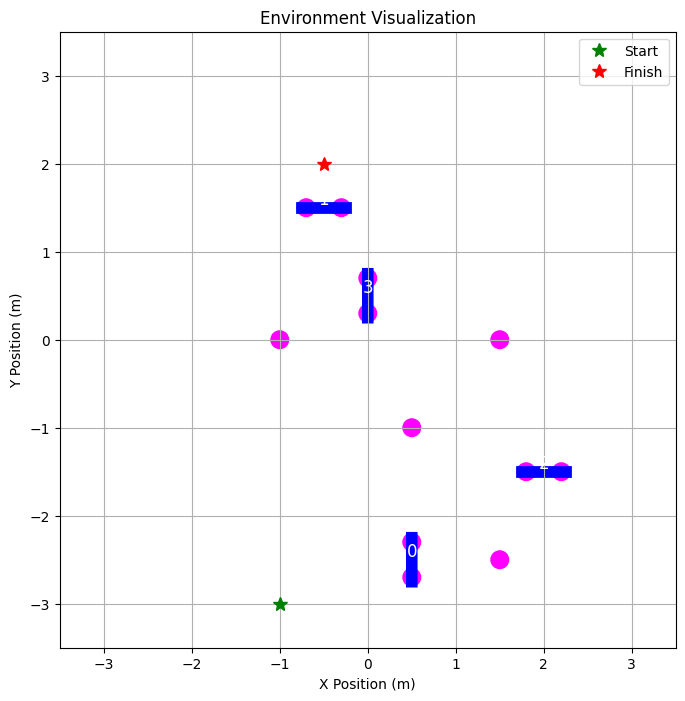

In [183]:
def augment_obstacles(obstacles, gates):
    """
    Add gate edges as obstacles by representing them as line segments.
    """
    augmented_obstacles = obstacles.copy()
    
    for gate in gates:
        x, y, _, _, _, yaw, _ = gate
        # Calculate the endpoints of the gate edge
        x1 = x - (GATE_WIDTH / 2) * np.cos(yaw)
        y1 = y - (GATE_WIDTH / 2) * np.sin(yaw)
        x2 = x + (GATE_WIDTH / 2) * np.cos(yaw)
        y2 = y + (GATE_WIDTH / 2) * np.sin(yaw)
        
        # Add the line segment as an obstacle (start and end points of the segment)
        augmented_obstacles = np.vstack((augmented_obstacles, [x1, y1, 0]))
        augmented_obstacles = np.vstack((augmented_obstacles, [x2, y2, 0]))
    
    return augmented_obstacles

# Update obstacles with augmented obstacles
obstacles = augment_obstacles(obstacles, NOMINAL_GATES)

plot_environment(gates, obstacles)

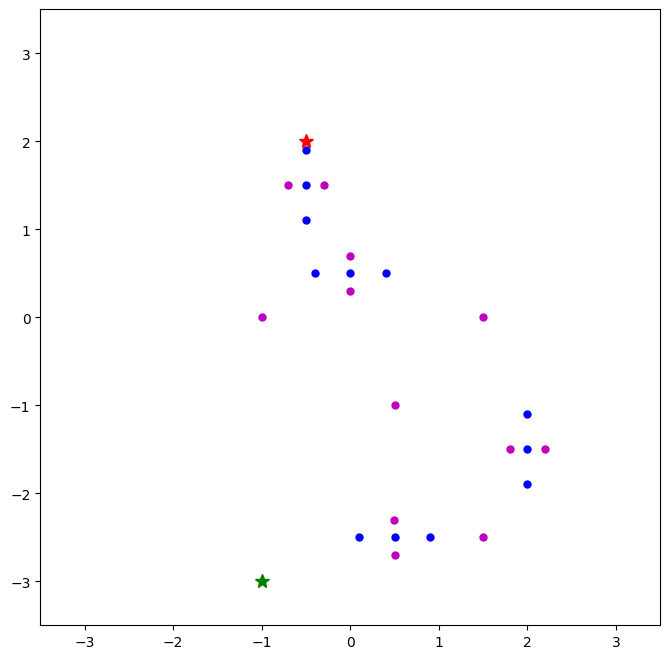

In [184]:
def augment_waypoints(waypoints):
    """
    Based on yaw angles, add waypoints to front and back of the gates
    """
    # x, y, z, r, p, y, type
    augmented_waypoints = []
    dist = 0.4
    
    for i, gate in enumerate(gates):
        x, y, z, r, p, yaw, gate_type = gate
        if gate_type == 0:
            # front
            augmented_waypoints.append([x + dist * np.sin(yaw), y + dist * np.cos(yaw), 0, 0, 0, yaw, 0])
            
            # add center waypoint
            augmented_waypoints.append([x, y, 0, 0, 0, yaw, 0])
            # back
            augmented_waypoints.append([x - dist * np.sin(yaw), y - dist * np.cos(yaw), 0, 0, 0, yaw, 0])
        
    return augmented_waypoints

augmented_waypoints = augment_waypoints(NOMINAL_GATES)

# plot obstacles augmented wayppoints as points
fig , ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)

# Plot obstacles as dots
for obs in obstacles:
    obs_x, obs_y = obs[0], obs[1]
    ax.plot(obs_x, obs_y, 'mo', markersize=5)
    
# Plot waypoints as dots
for wp in augmented_waypoints:
    wp_x, wp_y = wp[0], wp[1]
    ax.plot(wp_x, wp_y, 'bo', markersize=5)
    
# plot start and finish points, use stars

ax.plot(START[0], START[1], 'g*', label='Start', markersize=10)
ax.plot(END[0], END[1], 'r*', label='Finish', markersize=10)
plt.show()

In [187]:
from scipy.interpolate import CubicSpline, splprep, splev

def smooth_cubic_spline(path, num_points=300) -> np.ndarray:
    """
    Interpolates through the entire path using cubic splines.
    """
    # Ensure path is a NumPy array
    path = np.array(path)
    
    # Extract x and y coordinates
    x = path[:, 0]
    y = path[:, 1]
    
    # Parameterize the path
    t = np.linspace(0, 1, len(path))
    
    # Create cubic splines for x and y
    cs_x = CubicSpline(t, x)
    cs_y = CubicSpline(t, y)
    
    # Generate new parameter values
    t_new = np.linspace(0, 1, num_points)
    
    # Interpolate x and y coordinates
    x_smooth = cs_x(t_new)
    y_smooth = cs_y(t_new)
    
    # Return the smoothed path as a NumPy array
    return np.column_stack((x_smooth, y_smooth))


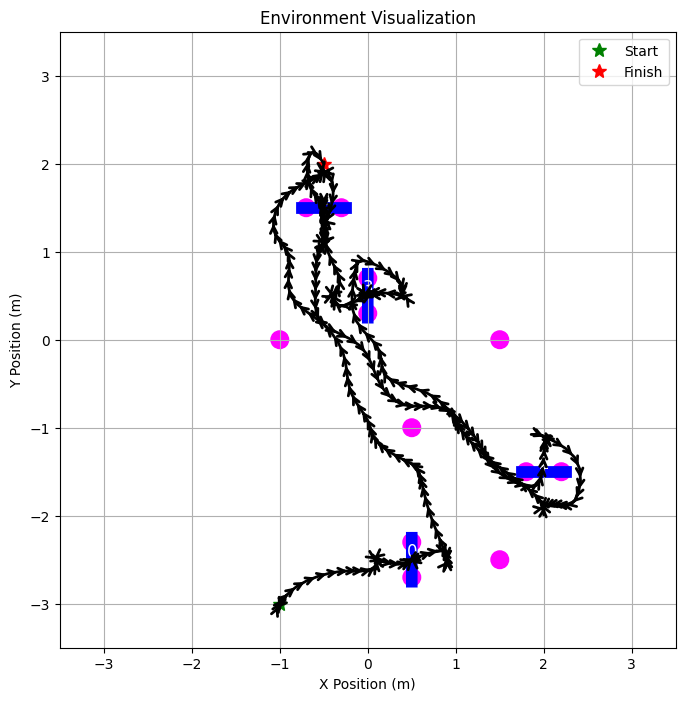

In [189]:
planner = RRTStar(x_range=(-3.5, 3.5), y_range=(-3.5, 3.5), obstacles=obstacles, waypoints=augmented_waypoints)
path = planner.plan(START, END)
cubic_path = smooth_cubic_spline(path)
plot_environment(gates, obstacles, path=cubic_path)